<center><h1>Glasses Survey</h1></center>

A problem that is project aims to address is that users will “give up” at different points in the survey. This project is going to analyze the effectiveness of the funnel system by seeing the ratio of people who continue down from the first question to the last question, and where people tend to give up. This will be useful to the survey providers so that they konw what questions people do not want to answer so that they can make necessary adjustments and get the user to the end goal. 

In [ ]:
 SELECT 
  question,
  COUNT(*) AS response_count,
  (COUNT(*) * 100.0 / (SELECT COUNT(*) FROM survey WHERE question = '1. What are you looking for?')) AS response_percentage
 FROM survey
 GROUP BY question;

 /*
Outputs:
       
       question                   response_count   response_percentage
1. What are you looking for?	        500              100
2. What's your fit?	                475              95
3. Which shapes do you like?	        380              76
4. Which colors do you like?	        361              72
5. When was your last eye exam?	        270              54

This is standard funnel behavior 
 */

#### A/B Testing
The purchase funnel is as follows:

Take the Style Quiz → Home Try-On → Purchase the Perfect Pair of Glasses. 

During the Home Try-On stage, the following A/B Test will be conducted:

* 50% of the users will get 3 pairs to try on
* 50% of the users will get 5 pairs to try on

#### Joining Tables

Each row will represent a single user from the browse table:

* If the user has any entries in home_try_on, then is_home_try_on will be ‘True’.
* number_of_pairs comes from home_try_on table
* If the user has any entries in is_purchase, then is_purchase will be ‘True’.

We'll us a LEFT JOIN to combine the three tables, starting with the top of the funnel (browse) and ending with the bottom of the funnel (purchase).

In [ ]:
SELECT
  q.user_id,
  h.user_id IS NOT NULL AS 'is_home_try_on',
  h.number_of_pairs,
  p.user_id IS NOT NULL AS 'is_purchase'
FROM quiz as 'q'
LEFT JOIN home_try_on AS 'h'
  ON h.user_id = q.user_id
LEFT JOIN purchase AS 'p'
  ON p.user_id = q.user_id
LIMIT 10;

/*
This will output the following table:

user_id  	is_home_try_on	  number_of_pairs	 is_purchase
4e8118dc	    True	             3	            False
291f1cca	    True	             5	            False
75122300	    False	           NULL	            True
*/

When the data in this format, we can analyze it in various ways:

* We can calculate overall conversion rates by aggregating across all rows.
* We can compare conversion from quiz → home_try_on → purchase.
* We can calculate the difference in purchase rates between customers who had 3 number_of_pairs with ones who had 5.


## Putting It All Together
Here we will analyze the results of each type of question to determine what style, fit, shape, and color are the most popular. The results of the A/B test will also be conducted to see if more or less glasses to try on result in a higher purchase rate. Each query output will be ordered by the last column (try_on → purchase) do to the purchase being the end goal, where the highest percentage of purchases will be first.

In [ ]:
-- Style

WITH funnels AS(
  SELECT
    q.style,
    q.user_id,
    h.user_id IS NOT NULL AS 'is_home_try_on',
    h.number_of_pairs,
    p.user_id IS NOT NULL AS 'is_purchase'
  FROM quiz as 'q'
  LEFT JOIN home_try_on AS 'h'
    ON h.user_id = q.user_id
  LEFT JOIN purchase AS 'p'
    ON p.user_id = q.user_id)
SELECT
  style,
  COUNT(*) AS 'responses',
  SUM(is_home_try_on) AS 'total_try_on',
  SUM(is_purchase) AS 'total_purchases',
  1.0 * SUM(is_home_try_on) / COUNT(user_id) AS 'browse_to_trying_on',
  1.0 * SUM(is_purchase) / SUM(is_home_try_on) AS 'trying_on_to_purchase'
FROM funnels
GROUP BY 1
ORDER BY 6 DESC;


-- Fit

WITH funnels AS(
  SELECT
    q.fit,
    q.user_id,
    h.user_id IS NOT NULL AS 'is_home_try_on',
    h.number_of_pairs,
    p.user_id IS NOT NULL AS 'is_purchase'
  FROM quiz as 'q'
  LEFT JOIN home_try_on AS 'h'
    ON h.user_id = q.user_id
  LEFT JOIN purchase AS 'p'
    ON p.user_id = q.user_id)
SELECT
  fit,
  COUNT(*) AS 'responses',
  SUM(is_home_try_on) AS 'total_try_on',
  SUM(is_purchase) AS 'total_purchases',
  1.0 * SUM(is_home_try_on) / COUNT(user_id) AS 'browse_to_trying_on',
  1.0 * SUM(is_purchase) / SUM(is_home_try_on) AS 'trying_on_to_purchase'
FROM funnels
GROUP BY 1
ORDER BY 6 DESC;

-- Shape

WITH funnels AS(
  SELECT
    q.shape,
    q.user_id,
    h.user_id IS NOT NULL AS 'is_home_try_on',
    h.number_of_pairs,
    p.user_id IS NOT NULL AS 'is_purchase'
  FROM quiz as 'q'
  LEFT JOIN home_try_on AS 'h'
    ON h.user_id = q.user_id
  LEFT JOIN purchase AS 'p'
    ON p.user_id = q.user_id)
SELECT
  shape,
  COUNT(*) AS 'responses',
  SUM(is_home_try_on) AS 'total_try_on',
  SUM(is_purchase) AS 'total_purchases',
  1.0 * SUM(is_home_try_on) / COUNT(user_id) AS 'browse_to_trying_on',
  1.0 * SUM(is_purchase) / SUM(is_home_try_on) AS 'trying_on_to_purchase'
FROM funnels
GROUP BY 1
ORDER BY 6 DESC;

-- Color

WITH funnels AS(
  SELECT
    q.color,
    q.user_id,
    h.user_id IS NOT NULL AS 'is_home_try_on',
    h.number_of_pairs,
    p.user_id IS NOT NULL AS 'is_purchase'
  FROM quiz as 'q'
  LEFT JOIN home_try_on AS 'h'
    ON h.user_id = q.user_id
  LEFT JOIN purchase AS 'p'
    ON p.user_id = q.user_id)
SELECT
  color,
  COUNT(*) AS 'responses',
  SUM(is_home_try_on) AS 'total_try_on',
  SUM(is_purchase) AS 'total_purchases',
  1.0 * SUM(is_home_try_on) / COUNT(user_id) AS 'browse_to_trying_on',
  1.0 * SUM(is_purchase) / SUM(is_home_try_on) AS 'trying_on_to_purchase'
FROM funnels
GROUP BY 1
ORDER BY 6 DESC;

-- A/B Test Results

WITH funnels AS(
  SELECT
    q.user_id,
    h.user_id IS NOT NULL AS 'is_home_try_on',
    h.number_of_pairs,
    p.user_id IS NOT NULL AS 'is_purchase'
  FROM quiz as 'q'
  LEFT JOIN home_try_on AS 'h'
    ON h.user_id = q.user_id
  LEFT JOIN purchase AS 'p'
    ON p.user_id = q.user_id)
SELECT
  number_of_pairs,
  COUNT(*) AS 'responses',
  SUM(is_home_try_on) AS 'total_try_on',
  SUM(is_purchase) AS 'total_purchases',
  1.0 * SUM(is_home_try_on) / COUNT(user_id) AS 'browse_to_trying_on',
  1.0 * SUM(is_purchase) / SUM(is_home_try_on) AS 'trying_on_to_purchase'
FROM funnels
GROUP BY 1
ORDER BY 6 DESC;

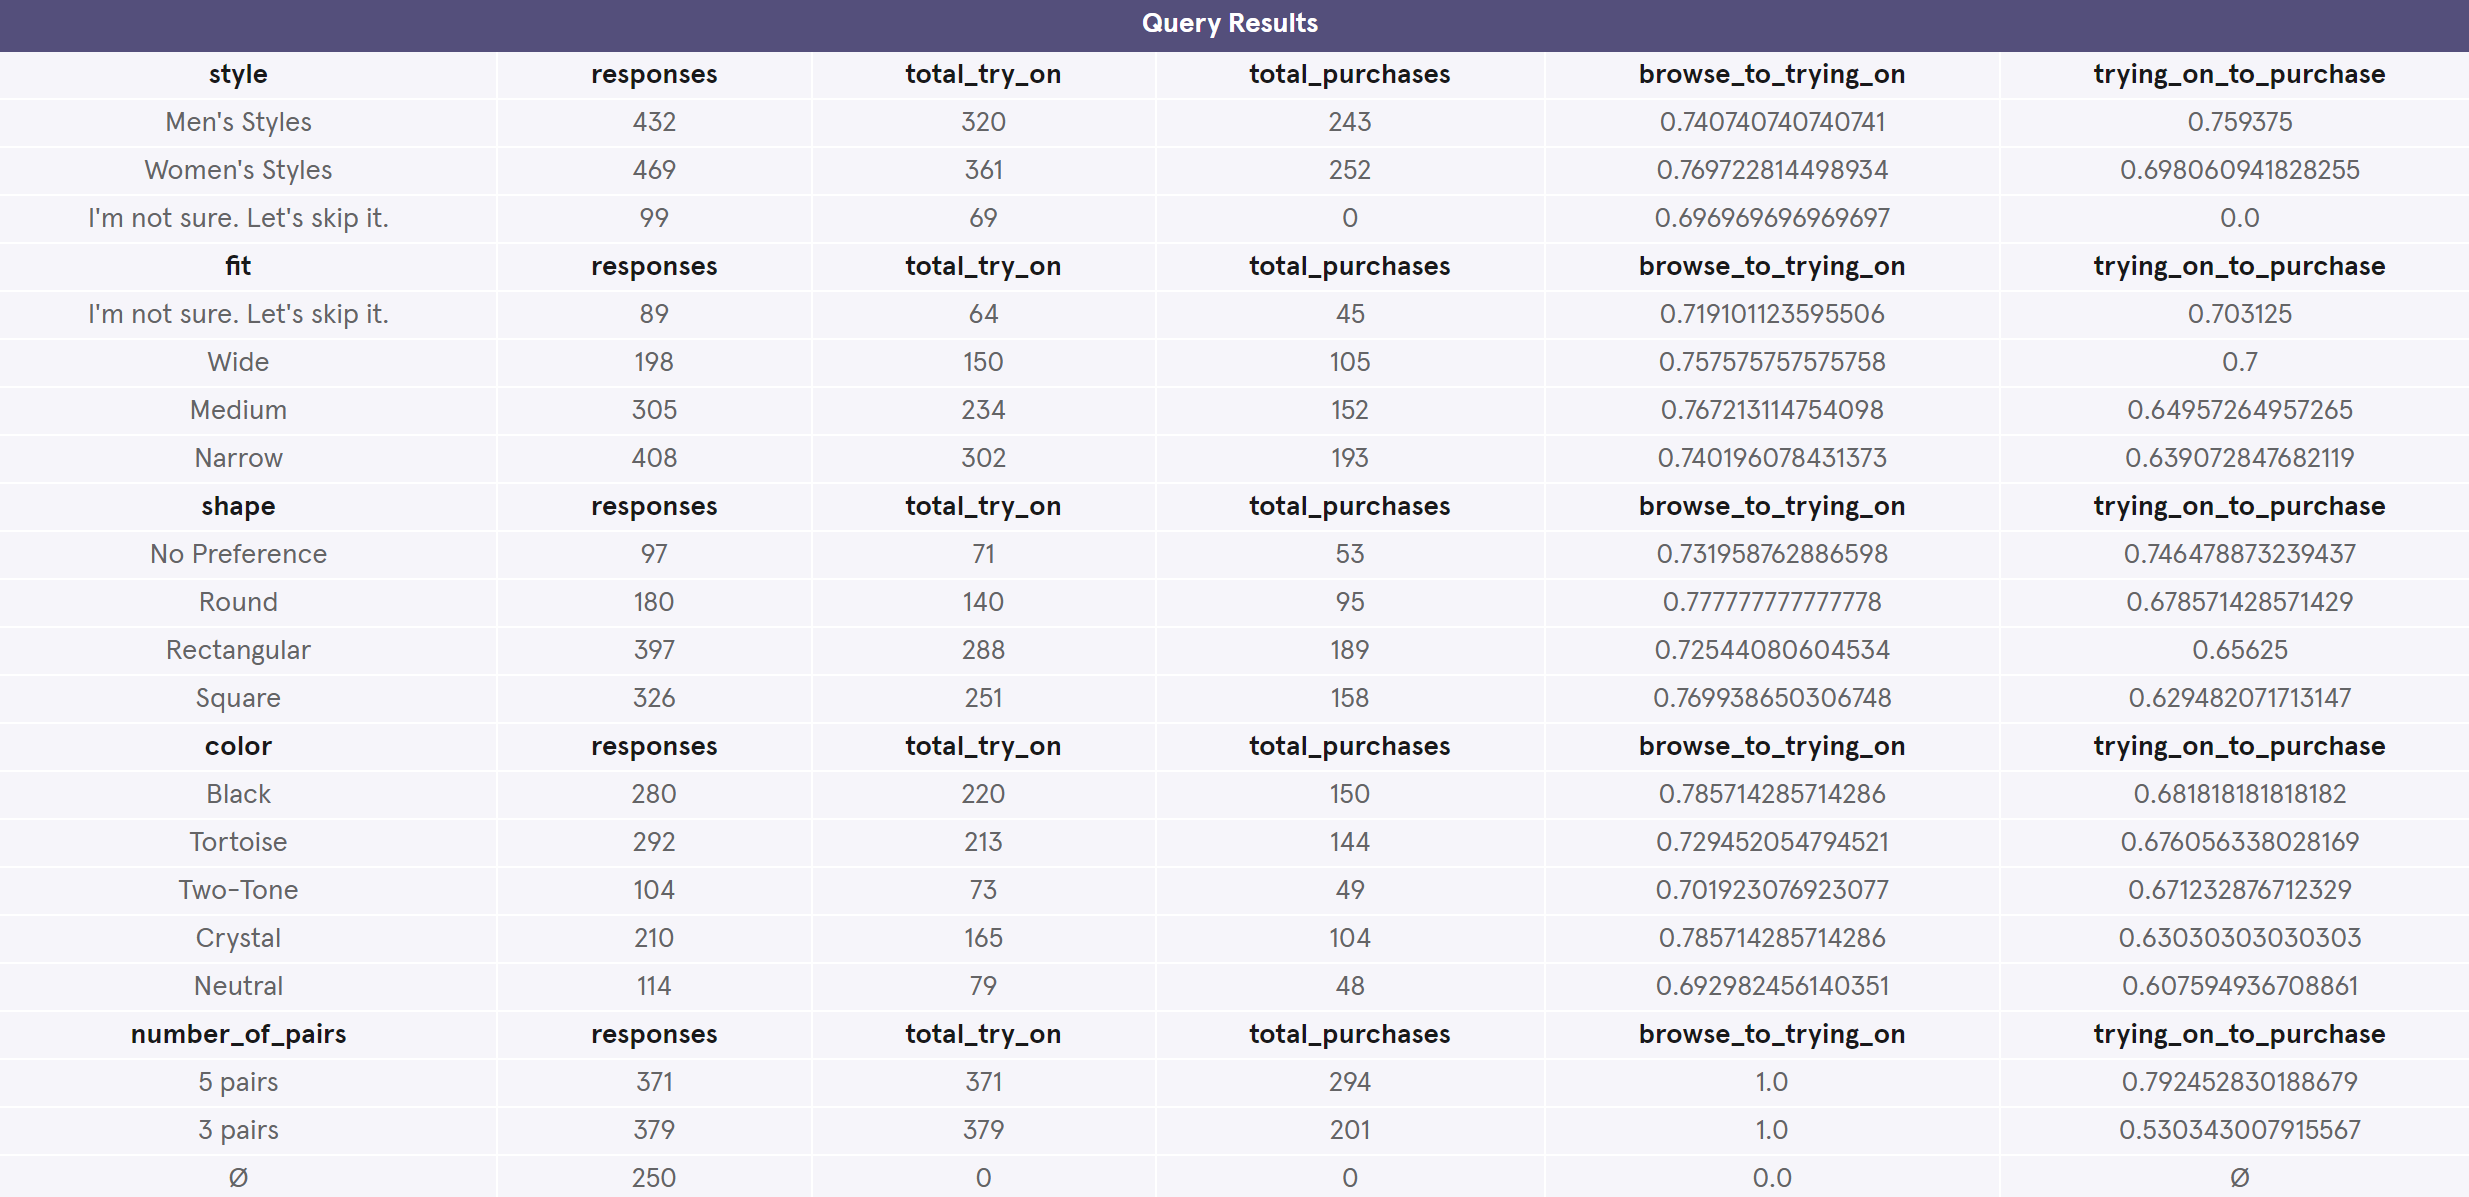

#### Results
The A/B test resulted in the following insights:
* People who recieve 5 glasses instead of 3 glasses to try on are around **30%** more likely to make a purchase.
* Black glasses were the most popular color and resulted in the highest purchase rate.
* Most customers prefer square/rectangular glasses, but customers who are unsure about shape in the trying on phase are around 10% more likely to make a purchase in the end.
* The majority of participants prefer narrow glasses, but again those who are unsure when trying on are more likely to make a purchase in the end.
* Men styles have a higher purchase rate after getting to try on glasses than women styles. Also people who are unsure about what style they like (either men or women) have a **0%** chance of following through and making a purchase.

#### Recommendations
Marketing should focus their efforts on advertising glasses that are:
* Black
* Both men and women styles
* Rectangular or square in shape
* Narrow in shape

In addition to telling customers that they get 5 different pairs of glasses to try on.